## Importing Libraries

In [31]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [32]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [33]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Forecasting O3 based on PM2.5 pre-trained model

In [34]:
# Importing dataset from station Aotizhongxin
df = pd.read_csv("datasets/cleaned_df.csv")

In [35]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [36]:
# Defining features and target
features_O3 = df.drop(columns = ['PM10','SO2','PM2.5','CO','NO2'])

In [37]:
features_O3

,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [38]:
features_O3.isna().sum()

O3      0
TEMP    0
PRES    0
DEWP    0
RAIN    0
wd      0
WSPM    0
dtype: int64

In [39]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_O3.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_O3 = features_O3[cols]

In [40]:
features_O3

,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,77.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,77.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,73.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,72.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,72.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,95.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,81.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,58.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,35.0,10.5,1014.4,-12.9,0.0,1.2,6


In [41]:
# Create sequences
SEQ_LENGTH = 1
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [42]:
# 10%, 20%, 30%, 40%, and 50%
fine_tuning_size = [0.1, 0.2, 0.3, 0.4, 0.5]

In [43]:
# Best parameters from Optuna
best_params_ann = {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [44]:
# This function splits the data to train and test and standardizes it.
def train_test_split_standardize(train_size):
    
    len_train = int(train_size * len(features_O3))
    
    # Why :-1, because I do not want to standardize the categorical column 'wd'
    train_df = features_O3.iloc[:len_train, :-1]
    test_df = features_O3.iloc[len_train:, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    # Standardizing train and test separately to avoid data leakage
    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_O3.iloc[:len_train, -1]
    test_df['wd'] = features_O3.iloc[len_train:, -1]
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    return X_train, y_train, X_test, y_test

In [45]:
# Testing the function
X_train_O3, y_train_O3, X_test_O3, y_test_O3 = train_test_split_standardize(0.3)

In [46]:
print("Train shape: ", X_train_O3.shape)
print("Test shape: ", X_test_O3.shape)

Train shape:  (10518, 1, 7)
Test shape:  (24544, 1, 7)


In [47]:
X_train_O3

array([[[ 6.66810768e-01, -1.30927509e+00,  1.30236737e+00, ...,
         -6.20225909e-02,  2.44235361e+00,  6.00000000e+00]],

       [[ 6.66810768e-01, -1.34717207e+00,  1.32307167e+00, ...,
         -6.20225909e-02,  2.70391712e+00,  3.00000000e+00]],

       [[ 5.86602067e-01, -1.34717207e+00,  1.35412812e+00, ...,
         -6.20225909e-02,  3.48860768e+00,  6.00000000e+00]],

       ...,

       [[-2.75641472e-01, -1.13035246e-02, -1.61693932e+00, ...,
         -6.20225909e-02, -8.70784300e-01,  1.00000000e+00]],

       [[-4.16006699e-01,  1.71192105e-02, -1.59623501e+00, ...,
         -6.20225909e-02, -7.83596461e-01,  1.00000000e+00]],

       [[-8.37102381e-01,  1.21335906e-01, -1.52376996e+00, ...,
         -6.20225909e-02,  1.09409591e-03,  4.00000000e+00]]])

In [71]:
mse_scores_ft = []
mae_scores_ft = []
rmse_scores_ft = []
mape_scores_ft = []
r2_scores_ft = []

for s in fine_tuning_size:
    
    # Training and test sets
    X_train_O3, y_train_O3, X_test_O3, y_test_O3 = train_test_split_standardize(s)
        
    # Loading the saved model
    pre_trained_model = tf.keras.models.load_model('pre_trained_models/LSTM_model.h5')
    
    
    pre_trained_model.compile(optimizer=Adam(learning_rate = best_params_ann['learning_rate']/10), loss='mse', metrics=['mae'])
    pre_trained_model.fit(X_train_O3, y_train_O3, epochs = 50, batch_size=32, shuffle=False)
    
    # Make predictions on the test data
    y_pred_ft = pre_trained_model.predict(X_test_O3)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_O3, y_pred_ft)
    mae = mean_absolute_error(y_test_O3, y_pred_ft)
    r2 = r2_score(y_test_O3, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_O3, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_O3, y_pred_ft))
    
    # Append to list scores
    mse_scores_ft.append(mse)
    mae_scores_ft.append(mae)
    r2_scores_ft.append(r2)
    rmse_scores_ft.append(rmse)
    mape_scores_ft.append(mape)

Epoch 1/50
110/110 [==============================] - 3s 3ms/step - loss: 0.1625 - mae: 0.2755
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1586 - mae: 0.2685
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1430 - mae: 0.2561
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1473 - mae: 0.2547
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1405 - mae: 0.2518
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1434 - mae: 0.2489
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1413 - mae: 0.2537
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1377 - mae: 0.2483
Epoch 9/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1357 - mae: 0.2464
Epoch 10/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1279 - mae: 0.2427
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1196 - mae: 0.2197
Epoch 37/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1137 - mae: 0.2177
Epoch 38/50
220/220 [==============================] - 1s 2ms/step - loss: 0.1206 - mae: 0.2223
Epoch 39/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1212 - mae: 0.2239
Epoch 40/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1159 - mae: 0.2197
Epoch 41/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1199 - mae: 0.2217
Epoch 42/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.2171
Epoch 43/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1176 - mae: 0.2201
Epoch 44/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2208
Epoch 45/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1132 - mae: 0.2185
Epoch 46/50
220/220 [===================

439/439 [==============================] - 2s 4ms/step - loss: 0.1148 - mae: 0.2218
Epoch 21/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1095 - mae: 0.2192
Epoch 22/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1084 - mae: 0.2197
Epoch 23/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1135 - mae: 0.2216
Epoch 24/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1120 - mae: 0.2202
Epoch 25/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1102 - mae: 0.2196
Epoch 26/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1117 - mae: 0.2201
Epoch 27/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1116 - mae: 0.2202
Epoch 28/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1116 - mae: 0.2206
Epoch 29/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1125 - mae: 0.2212
Epoch 30/50
439/439 [==============================]

In [77]:
mae_scores_ft 

[0.19577825635925625,
 0.19655816573380636,
 0.21943081596438707,
 0.1917637513915255,
 0.2103082270111823]

In [78]:
mse_scores_ft

[0.08221434508999889,
 0.08771048507758818,
 0.11057792506821092,
 0.08165480124589335,
 0.10015946473425762]

In [79]:
rmse_scores_ft

[0.2867304397687816,
 0.2961595601657799,
 0.3325325924901361,
 0.28575304240881383,
 0.3164798014633124]

In [80]:
mape_scores_ft

[0.7674963269796841,
 0.8443634309016786,
 0.893062921356881,
 0.8611786867085056,
 0.8831368090280343]

In [81]:
r2_scores_ft

[0.9260491562602765,
 0.9253442036406168,
 0.9234119343028914,
 0.9250186713510946,
 0.9228599671077999]

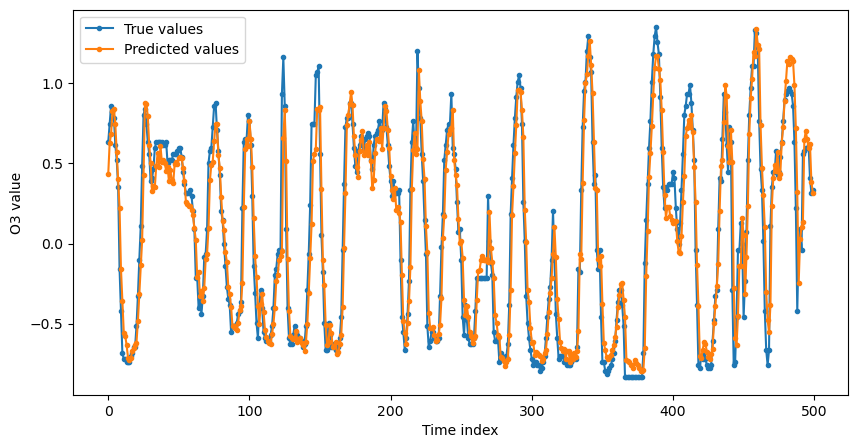

In [24]:
# Forecasting test set values

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.array(y_test_O3)[:500], marker = '.', label = 'True values')
plt.plot(y_pred_ft[:500], marker = '.', label = 'Predicted values')

plt.xlabel("Time index")
plt.ylabel("O3 value")
plt.legend()

#plt.savefig("actual_vs_forecasts_plot_O3.pdf")
plt.show()

## Forecasting O3 without Transfer Learning

In [25]:
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
    
    model.add(Dropout(best_params_ann['dropout_rate']))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [26]:
mse_scores_2 = []
mae_scores_2 = []
rmse_scores_2 = []
mape_scores_2 = []
r2_scores_2 = []

for s in fine_tuning_size:
    # Training set
    X_train_O3, y_train_O3, X_test_O3, y_test_O3 = train_test_split_standardize(s)
    
    # Loading the saved model
    model = build_ann_model(X_train_O3.shape[1:])
    model.fit(X_train_O3, y_train_O3, epochs = 50, shuffle = False, batch_size = 32)
    
    # Make predictions on the test data
    y_pred_ft = model.predict(X_test_O3)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_O3, y_pred_ft)
    mae = mean_absolute_error(y_test_O3, y_pred_ft)
    r2 = r2_score(y_test_O3, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_O3, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_O3, y_pred_ft))
    
    # Append to list scores
    mse_scores_2.append(mse)
    mae_scores_2.append(mae)
    r2_scores_2.append(r2)
    rmse_scores_2.append(rmse)
    mape_scores_2.append(mape)
    
    

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 6.3797 - mae: 1.8517
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 2.0556 - mae: 1.0674
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 1.5999 - mae: 0.9783
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 1.2404 - mae: 0.8726
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 1.0682 - mae: 0.7946
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.8988 - mae: 0.7353
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 0.7559 - mae: 0.6803
Epoch 8/50
110/110 [==============================] - 0s 2ms/step - loss: 0.6781 - mae: 0.6356
Epoch 9/50
110/110 [==============================] - 0s 2ms/step - loss: 0.6123 - mae: 0.5958
Epoch 10/50
110/110 [==============================] - 0s 2ms/step - loss: 0.5444 - mae: 0.5678
Epoch 11/50
110/110 [============================

220/220 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2371
Epoch 36/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1182 - mae: 0.2338
Epoch 37/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1177 - mae: 0.2352
Epoch 38/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1210 - mae: 0.2350
Epoch 39/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1196 - mae: 0.2351
Epoch 40/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1242 - mae: 0.2376
Epoch 41/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1265 - mae: 0.2374
Epoch 42/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1168 - mae: 0.2322
Epoch 43/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1212 - mae: 0.2368
Epoch 44/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1195 - mae: 0.2359
Epoch 45/50
220/220 [==============================]

439/439 [==============================] - 1s 1ms/step - loss: 0.1377 - mae: 0.2513
Epoch 20/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1414 - mae: 0.2499
Epoch 21/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1260 - mae: 0.2449
Epoch 22/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1307 - mae: 0.2497
Epoch 23/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1317 - mae: 0.2482
Epoch 24/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1311 - mae: 0.2476
Epoch 25/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1270 - mae: 0.2432
Epoch 26/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1306 - mae: 0.2463
Epoch 27/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1351 - mae: 0.2488
Epoch 28/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1317 - mae: 0.2466
Epoch 29/50
439/439 [==============================]

In [27]:
mae_scores_2

[0.20869382935569447,
 0.20551775258588556,
 0.22607699545143592,
 0.1994286216132016,
 0.23232556507545502]

In [28]:
mse_scores_2

[0.10663130433986588,
 0.09742505927238426,
 0.11081660862097267,
 0.09249602396268523,
 0.10776994785328263]

In [29]:
rmse_scores_2

[0.32654449059793655,
 0.312129875648558,
 0.33289128649000815,
 0.3041315898795869,
 0.32828333471756166]

In [30]:
r2_scores_2

[0.9040863864284487,
 0.9170755311761645,
 0.923246618200166,
 0.9150634786241436,
 0.9169985847643066]